## Calibrando Modelos de Classificação Binária com Previsão Conforme

Previsão Conforme (em inglês Conformal Prediction) é um método que transforma as previsões pontuais em conjuntos de previsões. Dessa forma, fornece previsões associadas à um nível de confiança estatística, permitindo que sejam medidos e controlados os riscos de uma previsão estar errada.


### Importar Libs

In [1]:
#CLONE_URL = f"https://github.com/ptocca/VennABERS"
#!git clone https://github.com/ptocca/VennABERS
#get_ipython().system(f"git clone {CLONE_URL}")

In [2]:
#CLONE_URL = f"https://github.com/ethen8181/machine-learning"
#!git clone https://github.com/ethen8181/machine-learning
#get_ipython().system(f"git clone {CLONE_URL}")

In [3]:
#!pip install -U numpy pandas sklearn wget matplotlib seaborn

In [4]:
#!pip install mapie --use-deprecated=legacy-resolver

In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("seaborn-whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

import sys

sys.path.append("VennABERS")
import VennABERS

sys.path.append("machine-learning/model_selection/prob_calibration/")
from calibration_module.utils import compute_calibration_summary

### Importar Dataset

In [6]:
credit_data_file = "./GiveMeSomeCreditDataset/GiveMeSomeCredit-training.csv"
credit = pd.read_csv(credit_data_file, index_col=0)
credit.shape

(150000, 11)

In [7]:
credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766,45,2,0.803,9120.000,13,0,6,0,2.000
2,0,0.957,40,0,0.122,2600.000,4,0,0,0,1.000
3,0,0.658,38,1,0.085,3042.000,2,1,0,0,0.000
4,0,0.234,30,0,0.036,3300.000,5,0,0,0,0.000
5,0,0.907,49,1,0.025,63588.000,7,0,1,0,0.000


### Pre-Process Dataset

In [8]:
# Split data into classification target and features
y = credit["SeriousDlqin2yrs"]
X = credit.drop("SeriousDlqin2yrs", axis = 1)

# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=100000, random_state=2)

# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=10000, random_state=42)

# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=10000, random_state=67)

In [9]:
# Fill all NAs with means

mean_imputer = SimpleImputer(strategy='mean').fit(X_train)

X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)
X_calib = mean_imputer.transform(X_calib)

### Check Target Event Rate %

In [10]:
print("Target Positive Ocurrences and Event Rate (%) - Train:", (y_train).sum(),"/", (y_train).count()," or ", np.round((y_train).mean()*100,2), "%")
print("Target Positive Ocurrences and Event Rate (%) - Test:", (y_test).sum(),"/", (y_test).count()," or ", np.round((y_test).mean()*100,2), "%")
print("Target Positive Ocurrences and Event Rate (%) - Calibration:", (y_calib).sum(),"/", (y_calib).count()," or ", np.round((y_calib).mean()*100,2), "%")

Target Positive Ocurrences and Event Rate (%) - Train: 6660 / 100000  or  6.66 %
Target Positive Ocurrences and Event Rate (%) - Test: 601 / 10000  or  6.01 %
Target Positive Ocurrences and Event Rate (%) - Calibration: 662 / 10000  or  6.62 %


### Train Model - Logistic Regression

In [11]:
# Fit the model
lr_model = LogisticRegression(random_state=2).fit(X_train, y_train)

### Train Model - Random Forest

In [12]:
# Fit the model
rf_model = RandomForestClassifier(random_state=2, n_estimators=50).fit(X_train, y_train)

### Train Model - Hist Gradient Boosting

In [13]:
# Fit the model
hgb_model = HistGradientBoostingClassifier(random_state=23, max_iter=50).fit(X_train, y_train)

### Model Evaluation

In [14]:
# Predict in test data
y_pred_test_lr = lr_model.predict(X_test)
y_pred_test_rf = rf_model.predict(X_test)
y_pred_test_hgb = hgb_model.predict(X_test)

# Create the classification report
print("Logistic Regression: \n", classification_report(y_test, y_pred_test_lr))
print("Random Forest: \n", classification_report(y_test, y_pred_test_rf))
print("Hist Gradient Boosting: \n", classification_report(y_test, y_pred_test_hgb))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      9399
           1       0.42      0.01      0.02       601

    accuracy                           0.94     10000
   macro avg       0.68      0.50      0.49     10000
weighted avg       0.91      0.94      0.91     10000

Random Forest: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      9399
           1       0.54      0.18      0.27       601

    accuracy                           0.94     10000
   macro avg       0.74      0.59      0.62     10000
weighted avg       0.93      0.94      0.93     10000

Hist Gradient Boosting: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      9399
           1       0.59      0.17      0.26       601

    accuracy                           0.94     10000
   macro avg       0.77      0.58      0.62     10000
weighted

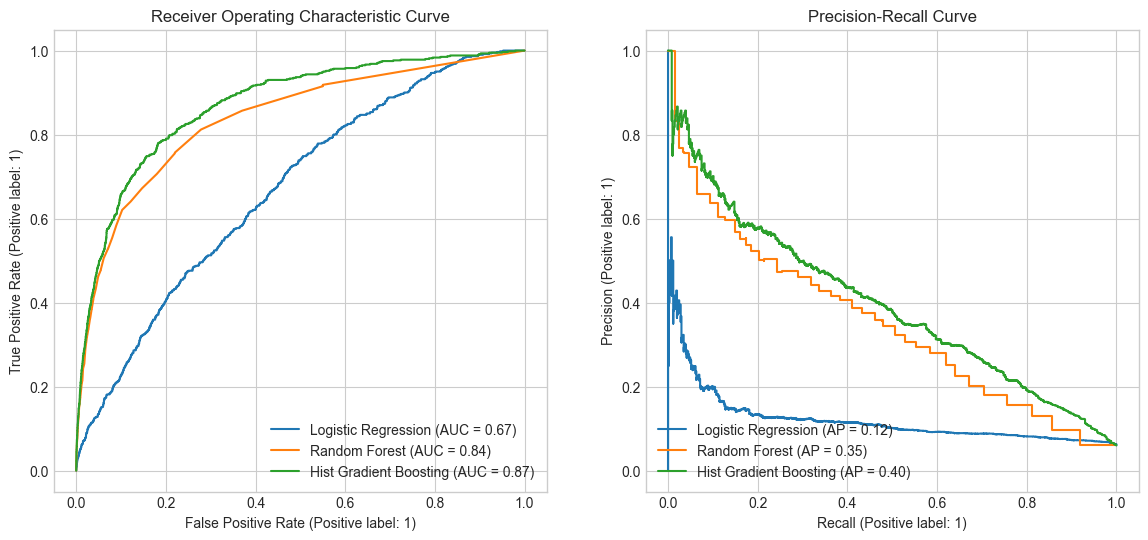

In [15]:
# Create the ROC and PRC AUC graphs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))

display_roc = RocCurveDisplay.from_estimator(lr_model, X_test, y_test, name="Logistic Regression", ax=ax[0])
display_roc = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest", ax=ax[0])
display_roc = RocCurveDisplay.from_estimator(hgb_model, X_test, y_test, name="Hist Gradient Boosting", ax=ax[0])
_ = display_roc.ax_.set_title("Receiver Operating Characteristic Curve")

display_prc = PrecisionRecallDisplay.from_estimator(lr_model, X_test, y_test, name="Logistic Regression", ax=ax[1])
display_prc = PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest", ax=ax[1])
display_prc = PrecisionRecallDisplay.from_estimator(hgb_model, X_test, y_test, name="Hist Gradient Boosting", ax=ax[1])
_ = display_prc.ax_.set_title("Precision-Recall Curve")
plt.show();

### Model Calibration - Venn-ABERS Predictions - Logistic Regression

In [16]:
# Use trained machine learning model to predict on the calibration set
y_pred_proba_calib_lr = lr_model.predict_proba(X_calib)[:, 1]
y_pred_proba_test_lr = lr_model.predict_proba(X_test)[:, 1]

#calibrPts: a list of pairs (score, label) corresponding to the scores and labels of the calibration examples.
# The score is a float and the label is an integer meant to take values 0 or 1.
lr_calib_points = zip(list(y_pred_proba_calib_lr), list(y_calib))

# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set
lr_p0, lr_p1 = VennABERS.ScoresToMultiProbs(lr_calib_points, y_pred_proba_test_lr)

# Get log-loss of Venn-ABERS Predictions
lr_log_loss_VA = lr_p1/(1-lr_p0+lr_p1)
lr_log_loss_VA

array([0.08333333, 0.05521589, 0.07255182, ..., 0.03713893, 0.05844702,
       0.01201723])

### Model Calibration - Venn-ABERS Predictions - Random Forest

In [17]:
# Use trained machine learning model to predict on the calibration set
y_pred_proba_calib_rf = rf_model.predict_proba(X_calib)[:, 1]
y_pred_proba_test_rf = rf_model.predict_proba(X_test)[:, 1]

#calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples.
# The score is a float and the label is an integer meant to take values 0 or 1.
rf_calib_points = zip(list(y_pred_proba_calib_rf), list(y_calib))

# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set
rf_p0, rf_p1 = VennABERS.ScoresToMultiProbs(rf_calib_points, y_pred_proba_test_rf)

# Get log-loss of Venn-ABERS Predictions
rf_log_loss_VA = rf_p1/(1-rf_p0+rf_p1)
rf_log_loss_VA

array([0.02710333, 0.02710333, 0.02710333, ..., 0.02710333, 0.02710333,
       0.03640667])

### Model Calibration - Venn-ABERS Predictions - Hist Gradient Boosting

In [18]:
# Get the predict class from the model
y_pred_calib_hgb = hgb_model.predict(X_calib)

# Use trained machine learning model to predict the "probabilities" on the calibration set
y_pred_proba_calib_hgb = hgb_model.predict_proba(X_calib)[:, 1]
y_pred_proba_test_hgb = hgb_model.predict_proba(X_test)[:, 1]

#calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples.
# The score is a float and the label is an integer meant to take values 0 or 1.
hgb_calib_points = zip(list(y_pred_proba_calib_hgb), list(y_calib))

# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set
hgb_p0, hgb_p1 = VennABERS.ScoresToMultiProbs(hgb_calib_points, y_pred_proba_test_hgb)

# Get log-loss of Venn-ABERS Predictions
hgb_log_loss_VA = hgb_p1/(1-hgb_p0+hgb_p1)
hgb_log_loss_VA

array([0.06463731, 0.0071048 , 0.0254567 , ..., 0.0048436 , 0.01045125,
       0.04596273])

### Comparing Model Calibrations - Calibration (Reliability Plots) - "predict_proba" x Venn-ABERS Predictions

In [19]:
# Function to calculate event rate per percentile

def quantile_table(data, var, target, quantile):

    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[var].rank(method='first'), quantile)
    grouped = data.groupby('bucket', as_index = False)
    
    quantile_table = pd.DataFrame()
    quantile_table['min_var'] = grouped.min()[var]
    quantile_table['max_var'] = grouped.max()[var]
    quantile_table['mean_var'] = grouped.mean()[var]

    quantile_table = quantile_table.sort_values(by="min_var").reset_index(drop = True)
    quantile_table['events']   = grouped.sum()[target]
    quantile_table['non_events'] = grouped.sum()['target0']
    quantile_table['total'] = quantile_table.events + quantile_table.non_events
    
    quantile_table['event_rate'] = (quantile_table.events/quantile_table.total)
    quantile_table['non_event_rate'] = (quantile_table.non_events/quantile_table.total)

    quantile_table['cumsum_events'] = (quantile_table.events.cumsum())
    quantile_table['cumsum_non_events'] = (quantile_table.non_events.cumsum())
    quantile_table['cumsum_total'] = (quantile_table.total.cumsum())
    quantile_table['cumsum_event_rate'] = (round(quantile_table.cumsum_events/quantile_table['events'].sum(), 2))

    quantile_table.index = range(1, quantile+1)
    quantile_table.index.rename('Quantiles', inplace=True)
    quantile_table = quantile_table.reset_index()
    
    return quantile_table

In [20]:
df_scores = pd.DataFrame({
    'y_true' : y_calib,
    'lr_y_pred' : y_pred_proba_calib_lr,
    'lr_p0' : lr_p0,
    'lr_p1' : lr_p1,
    'lr_log_loss_VA' : lr_log_loss_VA,
    'rf_y_pred' : y_pred_proba_calib_rf,
    'rf_p0' : rf_p0,
    'rf_p1' : rf_p1,
    'rf_log_loss_VA' : rf_log_loss_VA,
    'hgb_y_pred' : y_pred_proba_calib_hgb,
    'hgb_p0' : hgb_p0,
    'hgb_p1' : hgb_p1,
    'hgb_log_loss_VA' : hgb_log_loss_VA
})

df_scores.head()

,y_true,lr_y_pred,lr_p0,lr_p1,lr_log_loss_VA,rf_y_pred,rf_p0,rf_p1,rf_log_loss_VA,hgb_y_pred,hgb_p0,hgb_p1,hgb_log_loss_VA
147169,0,0.022,0.082,0.083,0.083,0.000,0.000,0.028,0.027,0.006,0.062,0.065,0.065
129260,0,0.072,0.036,0.056,0.055,0.020,0.000,0.028,0.027,0.012,0.005,0.007,0.007
129443,0,0.006,0.072,0.073,0.073,0.000,0.000,0.028,0.027,0.005,0.014,0.026,0.025
138662,0,0.014,0.056,0.059,0.058,0.000,0.000,0.028,0.027,0.006,0.014,0.021,0.021
21405,0,0.035,0.072,0.073,0.073,0.000,0.000,0.028,0.027,0.006,0.010,0.011,0.011


In [21]:
df_lr_pred = quantile_table(data=df_scores, target='y_true', var='lr_y_pred', quantile=10)
df_lr_calib = quantile_table(data=df_scores, target='y_true', var='lr_log_loss_VA', quantile=10)

df_rf_pred = quantile_table(data=df_scores, target='y_true', var='rf_y_pred', quantile=10)
df_rf_calib = quantile_table(data=df_scores, target='y_true', var='rf_log_loss_VA', quantile=10)

df_hgb_pred = quantile_table(data=df_scores, target='y_true', var='hgb_y_pred', quantile=10)
df_hgb_calib = quantile_table(data=df_scores, target='y_true', var='hgb_log_loss_VA', quantile=10)

In [22]:
df_lr_pred

,Quantiles,min_var,max_var,mean_var,events,non_events,total,event_rate,non_event_rate,cumsum_events,cumsum_non_events,cumsum_total,cumsum_event_rate
0,1,0.000,0.017,0.011,13,987,1000,0.013,0.987,13,987,1000,0.020
1,2,0.017,0.025,0.021,21,979,1000,0.021,0.979,34,1966,2000,0.050
2,3,0.025,0.033,0.029,29,971,1000,0.029,0.971,63,2937,3000,0.100
3,4,0.033,0.043,0.038,50,950,1000,0.050,0.950,113,3887,4000,0.170
4,5,0.043,0.055,0.049,59,941,1000,0.059,0.941,172,4828,5000,0.260
5,6,0.055,0.071,0.062,76,924,1000,0.076,0.924,248,5752,6000,0.370
6,7,0.071,0.088,0.079,69,931,1000,0.069,0.931,317,6683,7000,0.480
7,8,0.088,0.113,0.100,78,922,1000,0.078,0.922,395,7605,8000,0.600
8,9,0.113,0.150,0.129,120,880,1000,0.120,0.880,515,8485,9000,0.780
9,10,0.150,0.935,0.198,147,853,1000,0.147,0.853,662,9338,10000,1.000


In [23]:
df_lr_calib

,Quantiles,min_var,max_var,mean_var,events,non_events,total,event_rate,non_event_rate,cumsum_events,cumsum_non_events,cumsum_total,cumsum_event_rate
0,1,0.012,0.012,0.012,75,925,1000,0.075,0.925,75,925,1000,0.110
1,2,0.012,0.024,0.022,64,936,1000,0.064,0.936,139,1861,2000,0.210
2,3,0.024,0.037,0.029,63,937,1000,0.063,0.937,202,2798,3000,0.310
3,4,0.037,0.056,0.050,71,929,1000,0.071,0.929,273,3727,4000,0.410
4,5,0.056,0.073,0.063,64,936,1000,0.064,0.936,337,4663,5000,0.510
5,6,0.073,0.073,0.073,57,943,1000,0.057,0.943,394,5606,6000,0.600
6,7,0.073,0.073,0.073,65,935,1000,0.065,0.935,459,6541,7000,0.690
7,8,0.073,0.083,0.079,68,932,1000,0.068,0.932,527,7473,8000,0.800
8,9,0.083,0.126,0.123,76,924,1000,0.076,0.924,603,8397,9000,0.910
9,10,0.126,0.619,0.148,59,941,1000,0.059,0.941,662,9338,10000,1.000


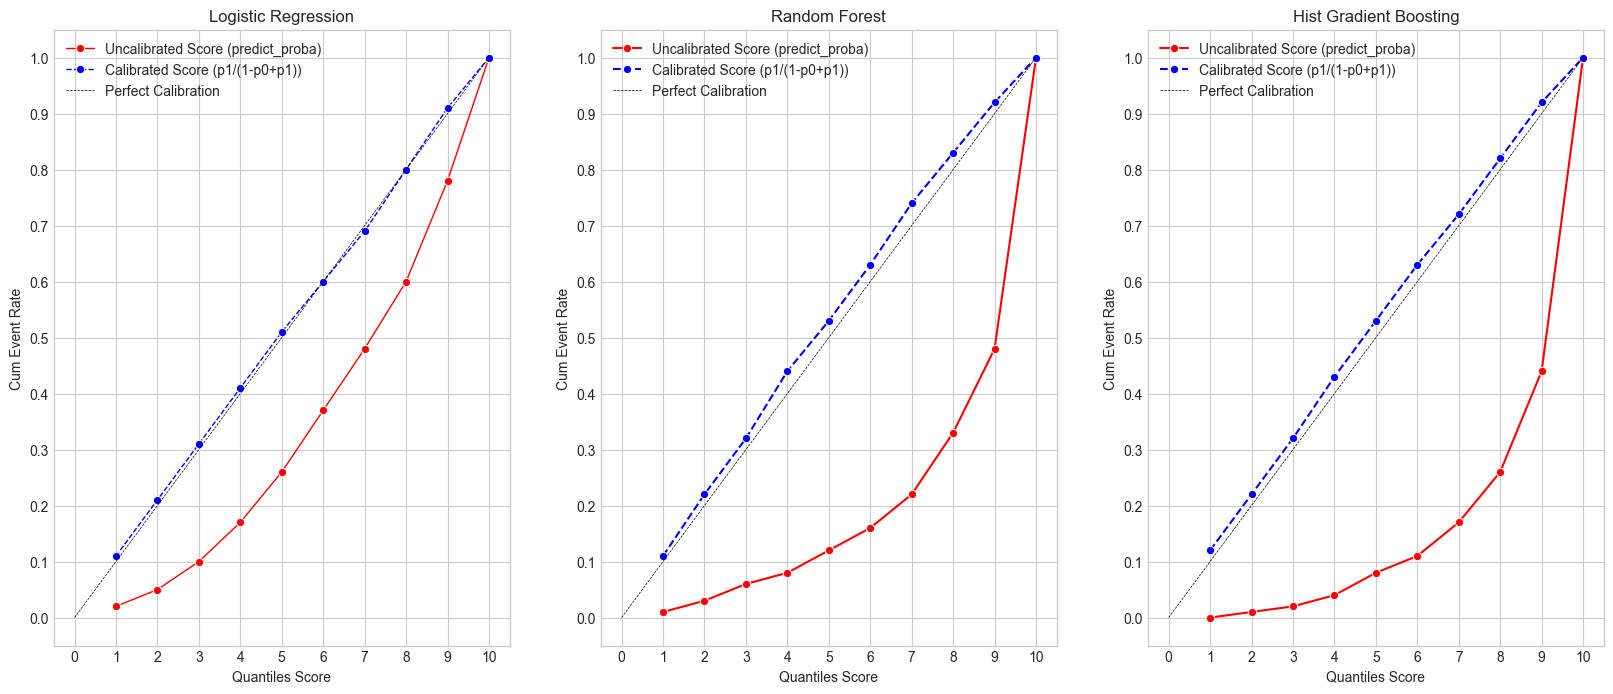

In [24]:
# Compare all scores
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 8))

x_values = [0,1,2,3,4,5,6,7,8,9,10]
y_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

sns.lineplot(x=df_lr_pred['Quantiles'], y=df_lr_pred['cumsum_event_rate'], linewidth=1, color='red', marker='o', ax=ax[0], label="Uncalibrated Score (predict_proba)")
sns.lineplot(x=df_lr_calib['Quantiles'], y=df_lr_calib['cumsum_event_rate'], linewidth=1, color='blue', linestyle='--', marker='o', ax=ax[0], label="Calibrated Score (p1/(1-p0+p1))")
ax[0].plot([0, 10], [0, 1], linewidth=0.5, color='black', linestyle='--', label="Perfect Calibration")
ax[0].set_xticks(x_values)
ax[0].set_yticks(y_values)
ax[0].legend(loc='best')
ax[0].set_title('Logistic Regression')
ax[0].set_ylabel('Cum Event Rate')
ax[0].set_xlabel('Quantiles Score')

sns.lineplot(x=df_rf_pred['Quantiles'], y=df_rf_pred['cumsum_event_rate'], linewidth=1.5, color='red', marker='o', ax=ax[1], label="Uncalibrated Score (predict_proba)")
sns.lineplot(x=df_rf_calib['Quantiles'], y=df_rf_calib['cumsum_event_rate'], linewidth=1.5, color='blue', linestyle='--', marker='o', ax=ax[1], label="Calibrated Score (p1/(1-p0+p1))")
ax[1].plot([0, 10], [0, 1], linewidth=0.5, color='black', linestyle='--', label="Perfect Calibration")
ax[1].set_xticks(x_values)
ax[1].set_yticks(y_values)
ax[1].legend(loc='best')
ax[1].set_title('Random Forest')
ax[1].set_ylabel('Cum Event Rate')
ax[1].set_xlabel('Quantiles Score')

sns.lineplot(x=df_hgb_pred['Quantiles'], y=df_hgb_pred['cumsum_event_rate'], linewidth=1.5, color='red', marker='o', ax=ax[2], label="Uncalibrated Score (predict_proba)")
sns.lineplot(x=df_hgb_calib['Quantiles'], y=df_hgb_calib['cumsum_event_rate'], linewidth=1.5, color='blue', linestyle='--', marker='o', ax=ax[2], label="Calibrated Score (p1/(1-p0+p1))")
ax[2].plot([0, 10], [0, 1], linewidth=0.5, color='black', linestyle='--', label="Perfect Calibration")
ax[2].set_xticks(x_values)
ax[2].set_yticks(y_values)
ax[2].legend(loc='best')
ax[2].set_title('Hist Gradient Boosting')
ax[2].set_ylabel('Cum Event Rate')
ax[2].set_xlabel('Quantiles Score')

plt.show();

### Comparing Model Calibrations - Measuring Calibration with Expected Calibrator Error (ECE) - "predict_proba" x Venn-ABERS Predictions

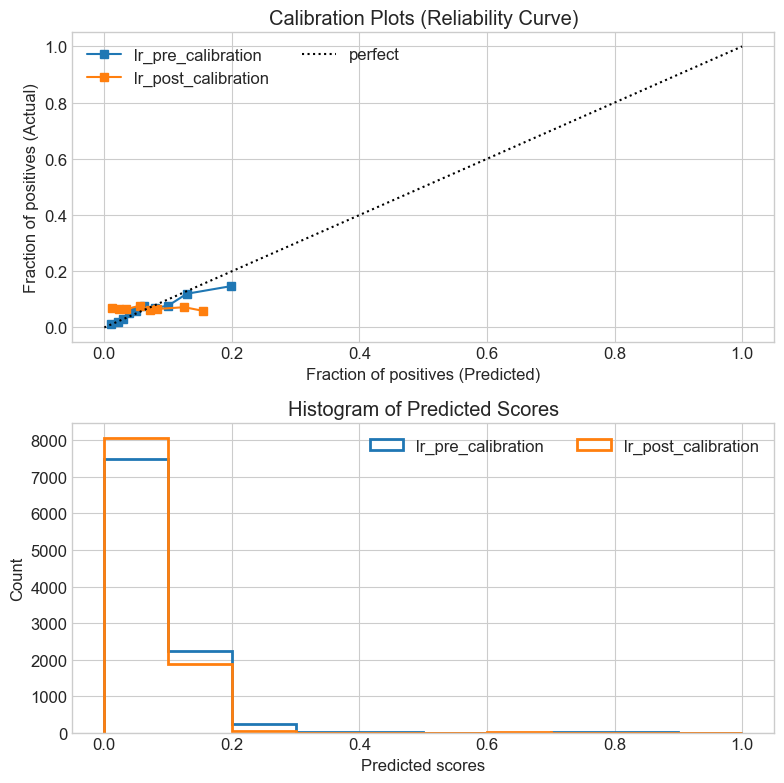

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.682,0.139,0.394,0.205,0.233,0.060,0.019,lr_pre_calibration
1,0.494,0.066,1.000,0.124,0.263,0.064,0.043,lr_post_calibration


In [25]:
# Create a dataframe with the label and probabilities

score_col = 'score'
label_col = 'label'

df_lr_eval_pre = pd.DataFrame({
    label_col: df_scores['y_true'],
    score_col: df_scores['lr_y_pred']
})

df_lr_eval_post = pd.DataFrame({
    label_col: df_scores['y_true'],
    score_col: df_scores['lr_log_loss_VA']
})

# key to the dictionary is for giving the result
# a descriptive name
eval_lr_dict = {
    'lr_pre_calibration': df_lr_eval_pre,
    'lr_post_calibration': df_lr_eval_post
}

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['font.size'] = 12

n_bins = 10
df_lr_result = compute_calibration_summary(eval_lr_dict, label_col, score_col, n_bins=n_bins)
df_lr_result

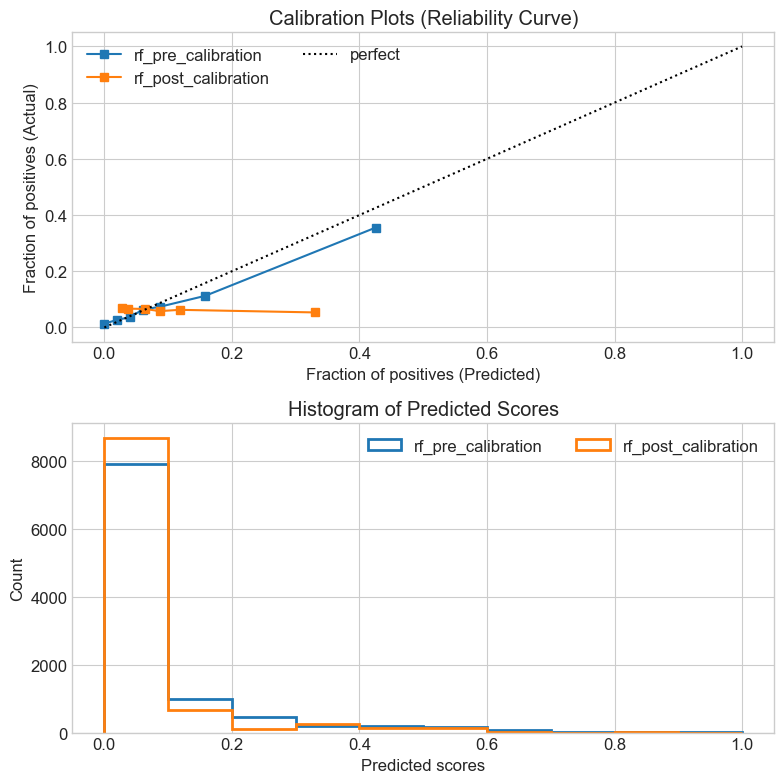

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.830,0.427,0.423,0.425,0.360,0.051,0.027,rf_pre_calibration
1,0.477,0.066,1.000,0.124,0.283,0.072,0.094,rf_post_calibration


In [26]:
# Create a dataframe with the label and probabilities

score_col = 'score'
label_col = 'label'

df_rf_eval_pre = pd.DataFrame({
    label_col: df_scores['y_true'],
    score_col: df_scores['rf_y_pred']
})

df_rf_eval_post = pd.DataFrame({
    label_col: df_scores['y_true'],
    score_col: df_scores['rf_log_loss_VA']
})

# key to the dictionary is for giving the result
# a descriptive name
eval_rf_dict = {
    'rf_pre_calibration': df_rf_eval_pre,
    'rf_post_calibration': df_rf_eval_post
}

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['font.size'] = 12

n_bins = 10
df_rf_result = compute_calibration_summary(eval_rf_dict, label_col, score_col, n_bins=n_bins)
df_rf_result

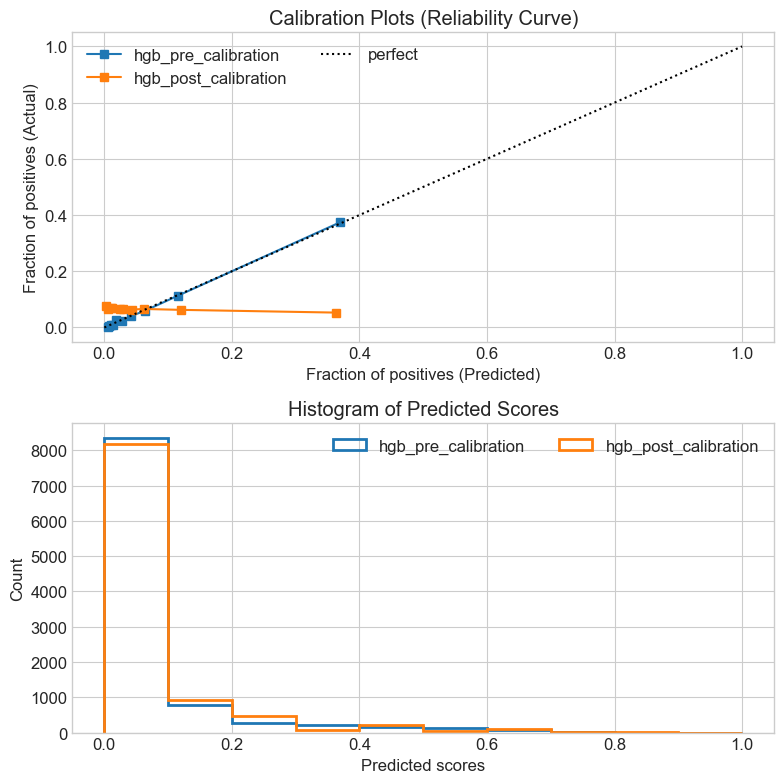

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.869,0.396,0.544,0.458,0.174,0.048,0.005,hgb_pre_calibration
1,0.475,0.066,1.000,0.124,0.326,0.076,0.107,hgb_post_calibration


In [27]:
# Create a dataframe with the label and probabilities

score_col = 'score'
label_col = 'label'

df_hgb_eval_pre = pd.DataFrame({
    label_col: df_scores['y_true'],
    score_col: df_scores['hgb_y_pred']
})

df_hgb_eval_post = pd.DataFrame({
    label_col: df_scores['y_true'],
    score_col: df_scores['hgb_log_loss_VA']
})

# key to the dictionary is for giving the result
# a descriptive name
eval_hgb_dict = {
    'hgb_pre_calibration': df_hgb_eval_pre,
    'hgb_post_calibration': df_hgb_eval_post
}

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['font.size'] = 12

n_bins = 10
df_hgb_result = compute_calibration_summary(eval_hgb_dict, label_col, score_col, n_bins=n_bins)
df_hgb_result